In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import time
import copy
import operator
import numpy as np
import random
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import imageio

# Suggestion Engine Prototype

Minimizing the distance between reality and goals

provide goals and current gym status and then get and implement route suggestions given by the engine

Contrast with a pure mathematical approach of minimizing the N-dimensional distance

## Methodology

- Each column will represent a field. 
- We will use 1 hot representation. 
- A gym will be a stacked collection of routes
- We can know the mean of any category by summing and dividing by the rows.
- The goals are stored the same way, so we can get the distance between each field

## How the array looks

- 0-5: Styles: [balance,toe-hooking,heel-hooking,finger-strength,powerful]
- 5-10: Techniques: [balance,toe-hooking,heel-hooking,finger-strength,powerful]
- 10-15: grade: [blue,pink,purple,green,yellow]
- 15-18: length: [short,medium,long]
- 18-23: R: [1,2,3,4,5]
- 23-28: I: [1,2,3,4,5]
- 28-33: C: [1,2,3,4,5]
- 33-38: Location: [wave-wall,barrel,roof,accordian,shield]


In [2]:
route_dictionary = {0:'balance',
                   1:'toe-hooking',
                   2:'heel-hooking',
                   3:'finger-strength',
                   4:'powerful',
                    
                   5:'balance',
                   6:'toe-hooking',
                   7:'heel-hooking',
                   8:'finger-strength',
                   9:'powerful',
                    
                    10:'blue',
                    11:'pink',
                    12:'purple',
                    13:'green',
                    14:'yellow',
                    
                    15:'short',
                    16:'medium',
                    17:'long',
                    
                    18:'1',
                    19:'2',
                    20:'3',
                    21:'4',
                    22:'5',
                    
                    23:'1',
                    24:'2',
                    25:'3',
                    26:'4',
                    27:'5',
                    
                    28:'1',
                    29:'2',
                    30:'3',
                    31:'4',
                    32:'5',
                    
                    33:'wave-wall',
                    34:'barrel',
                    35:'roof',
                    36:'accordian',
                    37:'shield'
                   }

array_dictionary = np.array(['balance','toe-hooking','heel-hooking','finger-strength','powerful',\
                    'balance','toe-hooking','heel-hooking','finger-strength','powerful',
                    'blue','pink','purple','green','yellow',
                     'short','medium','long',
                     '1','2','3','4','5',
                    '1','2','3','4','5',
                    '1','2','3','4','5',
                    'wave-wall','barrel','roof','accordian','shield'])

def convert_array_to_readable(array):
    mask = np.where(array > 0)[0]
    return array_dictionary[mask]

In [3]:
"""
Gen ints between 0-5,5-10,10-15,15-18,18-23,23-28,28-33,33-38

can gen multiple in a given category for instance multiple styles
"""

def gen_random_route(num_routes):
    routes = np.zeros((num_routes,38))
    for n in range(num_routes):
        style = np.random.choice(np.arange(0,5))
        technique = np.random.choice(np.arange(5,10))
        grade = np.random.choice(np.arange(10,15))
        length = np.random.choice(np.arange(15,18))
        R = np.random.choice(np.arange(18,23))
        I = np.random.choice(np.arange(23,28))
        C = np.random.choice(np.arange(28,33))
        Location = np.random.choice(np.arange(33,38))
        mask = np.array([style,technique,grade,length,R,I,C,Location])
        routes[n][mask] = 1
    return routes

In [4]:
def make_default_goals(num_routes):
    goals = np.zeros(38)
    by_5 = num_routes / 5
    by_3 = num_routes / 3
    styles = by_5
    techniques = by_5
    grades = by_5
    length = by_3
    R = by_5
    I = by_5
    C = by_5
    Location = by_5
    
    goals[0:5] = np.full(5,styles)
    goals[5:10] = np.full(5,techniques)
    goals[10:15] = np.full(5,grades)
    goals[15:18] = np.full(3,length)
    goals[18:23] = np.full(5,R)
    goals[23:28] = np.full(5,I)
    goals[28:33] = np.full(5,C)
    goals[33:38] = np.full(5,Location)
    return goals

def random_num(max_num,N):
    arr = np.zeros(N)
    arr[0] = np.random.random() * max_num
    max_num -= arr[0]
    for i in range(1,N-1):
        arr[i] = np.random.random() * max_num
        max_num -= arr[i]
    arr[-1] = max_num
    return arr

def gen_random_goals(num_routes):
    goals = np.zeros(38)
    
    styles = random_num(num_routes,5)
    techniques = random_num(num_routes,5)
    grades = random_num(num_routes,5)
    length = random_num(num_routes,3)
    R = random_num(num_routes,5)
    I = random_num(num_routes,5)
    C = random_num(num_routes,5)
    Location = random_num(num_routes,5)
    
    goals[0:5] = styles
    goals[5:10] = techniques
    goals[10:15] = grades
    goals[15:18] = length
    goals[18:23] = R
    goals[23:28] = I
    goals[28:33] = C
    goals[33:38] = Location
    return goals

## Test functions

In [5]:
# Test readable
# mask = np.array([1,6,11,16,20,24,32,35])

# arr_route = np.zeros(38)
# arr_route[mask] = 1
# readable_array = convert_array_to_readable(arr_route)
    
# Test ran gen
# ran_routes = gen_random_route(5)
# print('ran_routes',ran_routes.shape)
# readable_routes = [convert_array_to_readable(route) for route in ran_routes]
# print('readable_routes',readable_routes)

# test random num gen for goals
# styles = random_num(5,5)
# print('styles',styles,np.sum(styles))

# Test default goal gen
# goals = make_default_goals(5)
# print(goals)

# test random goals
# ran_goals = gen_random_goals(5)
# print('ran goals',ran_goals)

## Gym class

To hold the current distribution of routes. And the goals of the gym, and return the L2 distance

In [6]:
class Gym(object):
    def __init__(self,routes,goals):
        self.routes = routes
        self.goals = goals
        self.index = 0
    
    def update_route(self,route):
        self.routes[self.index][:] = route
        self.index = (self.index + 1) % len(self)
        
    def get_route(self,index):
        return Gym.convert_array_to_readable(self.routes[index])
    
    @staticmethod
    def convert_array_to_readable(array):
        mask = np.where(array > 0)[0]
        return array_dictionary[mask]
    
    @property
    def get_index(self):
        return self.index
        
    @property
    def L2(self):
        # mean columns in routes
        current_dist = np.sum(self.routes,axis = 0)
        nd_distance = self.goals - current_dist
        return nd_distance
    
    @property
    def loss(self):
        current_dist = np.sum(self.routes,axis = 0)
        nd_distance = self.goals - current_dist
        return np.sum((nd_distance)**2)
    
    def __len__(self):
        # Return number of routes
        return self.routes.shape[0]

# Test Gym class

In [7]:
routes = gen_random_route(10)
goals = gen_random_goals(10)

elevation = Gym(routes,goals)

In [8]:
print('Goal shape',goals.shape)
print('routes shape',routes.shape)
print('Number of routes',len(elevation))
print('5th route',elevation.get_route(5))
print('distance',elevation.L2)
print('routes',np.sum(routes,axis=0))
print('goals',goals)

Goal shape (38,)
routes shape (10, 38)
Number of routes 10
5th route ['powerful' 'balance' 'yellow' 'medium' '5' '1' '1' 'barrel']
distance [ 2.26035707 -0.73733353 -1.47705242 -0.89984587  0.85387475 -0.07463293
  0.69546004 -1.95586052  1.72850059 -0.39346717  4.89786899 -1.63554119
  2.51032864 -2.58655522 -3.18610121  0.77027364 -1.47697131  0.70669767
  1.50337662  5.47878794 -1.9906675  -0.991943   -3.99955406  0.44156027
  3.68892567 -2.87457204  0.36586262 -1.62177652 -2.24301827  5.99146716
 -0.52103388 -0.47697723 -2.75043778 -2.89022006  0.55041843  2.33058137
  0.84264797 -0.83342771]
routes [4. 1. 2. 1. 2. 6. 1. 2. 0. 1. 0. 2. 0. 4. 4. 2. 5. 3. 2. 1. 2. 1. 4. 2.
 1. 5. 0. 2. 4. 1. 1. 1. 3. 3. 3. 1. 1. 2.]
goals [6.26035707e+00 2.62666467e-01 5.22947585e-01 1.00154131e-01
 2.85387475e+00 5.92536707e+00 1.69546004e+00 4.41394768e-02
 1.72850059e+00 6.06532832e-01 4.89786899e+00 3.64458805e-01
 2.51032864e+00 1.41344478e+00 8.13898791e-01 2.77027364e+00
 3.52302869e+00 3.7066

# Network

In [9]:
class Network(nn.Module):
    def __init__(self,state_space,seed,hidden_dims=(32,32),activation_fc=F.relu):
        super(Network,self).__init__()
        self.activation_fc = activation_fc
        self.seed = torch.manual_seed(seed)
        self.input_layer = nn.Linear(state_space,hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i],hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        
        # Outputs, we softmax over the various classes for 1 per class (can change this for multi class)
        self.style = nn.Linear(hidden_dims[-1],5)
        self.techniques = nn.Linear(hidden_dims[-1],5)
        self.grades = nn.Linear(hidden_dims[-1],5)
        self.length = nn.Linear(hidden_dims[-1],3)
        self.R = nn.Linear(hidden_dims[-1],5)
        self.I = nn.Linear(hidden_dims[-1],5)
        self.C = nn.Linear(hidden_dims[-1],5)
        self.Location = nn.Linear(hidden_dims[-1],5)
        
    def forward(self,state):
        x = state
        if not isinstance(state,torch.Tensor):
            x = torch.tensor(x,dtype=torch.float32) #device = self.device,
            x = x.unsqueeze(0)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
            
        # Outputs
        S = F.softmax(self.style(x),dim=1)
        T = F.softmax(self.techniques(x),dim=1)
        G = F.softmax(self.grades(x),dim=1)
        L = F.softmax(self.length(x),dim=1)
        R = F.softmax(self.R(x),dim=1)
        I = F.softmax(self.I(x),dim=1)
        C = F.softmax(self.C(x),dim=1)
        Location = F.softmax(self.Location(x),dim=1)
        # Cat outputs
        route = torch.cat([S,T,G,L,R,I,C,Location],dim=1)
#         log_probs = torch.log(route)
        return route

In [11]:
state_space = 38
seed = 1234
suggestion_engine = Network(state_space,seed)
optimizer = optim.Adam(suggestion_engine.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

## Test network outputs

In [12]:
test_routes = gen_random_route(10)
output = suggestion_engine(test_routes[0]).squeeze(0)
# print('output[:5]',output.detach().cpu().numpy()[:5])
# print('output[5:10]',output.detach().cpu().numpy()[5:10])
print('output',output,output.shape)
# print('output[:5]',np.sum(output.detach().cpu().numpy()[:5]))
# print('output[5:10]',np.sum(output.detach().cpu().numpy()[5:10]))
print('distance',elevation.L2)
print('loss',elevation.loss)

output tensor([0.1939, 0.2060, 0.1828, 0.1946, 0.2227, 0.2413, 0.1523, 0.2260, 0.2043,
        0.1761, 0.2018, 0.2063, 0.1940, 0.1934, 0.2044, 0.3278, 0.3694, 0.3028,
        0.1925, 0.1990, 0.1965, 0.2176, 0.1943, 0.2186, 0.2108, 0.1974, 0.1898,
        0.1833, 0.1928, 0.1904, 0.2101, 0.1834, 0.2233, 0.2016, 0.2058, 0.1857,
        0.1963, 0.2107], grad_fn=<SqueezeBackward1>) torch.Size([38])
distance [ 2.26035707 -0.73733353 -1.47705242 -0.89984587  0.85387475 -0.07463293
  0.69546004 -1.95586052  1.72850059 -0.39346717  4.89786899 -1.63554119
  2.51032864 -2.58655522 -3.18610121  0.77027364 -1.47697131  0.70669767
  1.50337662  5.47878794 -1.9906675  -0.991943   -3.99955406  0.44156027
  3.68892567 -2.87457204  0.36586262 -1.62177652 -2.24301827  5.99146716
 -0.52103388 -0.47697723 -2.75043778 -2.89022006  0.55041843  2.33058137
  0.84264797 -0.83342771]
loss 212.44812766440637


In [13]:
def route_from_suggestion(suggestion):
    route = np.zeros(38)
    
    styles = suggestion[0:5] 
    techniques     = suggestion[5:10] 
    grades     = suggestion[10:15] 
    length     = suggestion[15:18] 
    R     = suggestion[18:23] 
    I     = suggestion[23:28] 
    C     = suggestion[28:33] 
    Location     = suggestion[33:38] 
    
    values_5 = np.arange(5)
    values_3 = np.arange(3)
    
    route_style = np.random.choice(values_5,p=styles)
    route_techniques = np.random.choice(values_5,p=techniques) + 5
    route_grades = np.random.choice(values_5,p=grades) + 10
    route_length = np.random.choice(values_3,p=length) + 15
    route_R = np.random.choice(values_5,p=R) + 18
    route_I = np.random.choice(values_5,p=I) + 23
    route_C = np.random.choice(values_5,p=C) + 28
    route_Locations = np.random.choice(values_5,p=Location) + 33
    
    mask = np.array([route_style,route_techniques,route_grades,\
                           route_length,route_R,route_I,route_C,route_Locations])
#     print('mask',mask)
    route[mask] = 1
    return route

# Math create next route

For comparison

- minus means we need to get rid of
- plus means we need to boost occurances of

In [14]:
def route_from_distance(distance):
    route = np.zeros(38)
    
    styles = distance[0:5] 
    techniques     = distance[5:10] 
    grades     = distance[10:15] 
    length     = distance[15:18] 
    R     = distance[18:23] 
    I     = distance[23:28] 
    C     = distance[28:33] 
    location     = distance[33:38] 
    
    r_styles = np.where(styles == np.max(styles))[0]
    r_techniques = np.where(techniques == np.max(techniques))[0] + 5
    r_grades = np.where(grades == np.max(grades))[0] + 10
    r_length = np.where(length == np.max(length))[0] + 15
    r_R = np.where(R == np.max(R))[0] + 18
    r_I = np.where(I == np.max(I))[0] + 23
    r_C = np.where(C == np.max(C))[0] + 28
    r_location = np.where(location == np.max(location))[0] + 33
    
    mask = np.array([r_styles,r_techniques,r_grades,r_length,r_R,r_I,r_C,r_location])
#     print(mask)
    route[mask] = 1
    return route

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def probabilistic_route(distance):
    route = np.zeros(38)
    epsilon = 0
    arr_5 = np.arange(5)
    arr_3 = np.arange(3)
    
    styles = distance[0:5] 
    techniques     = distance[5:10] 
    grades     = distance[10:15] 
    length     = distance[15:18] 
    R     = distance[18:23] 
    I     = distance[23:28] 
    C     = distance[28:33] 
    location     = distance[33:38] 
    
    r_style_prob = softmax(styles+np.abs(np.min(styles))+epsilon)
    r_tech_prob = softmax(techniques+np.abs(np.min(techniques))+epsilon)
    r_grad_prob = softmax(grades+np.abs(np.min(grades))+epsilon)
    length_prob = softmax(length+np.abs(np.min(length))+epsilon)
    r_prob = softmax(R+np.abs(np.min(R))+epsilon)
    i_prob =softmax(I+np.abs(np.min(I))+epsilon)
    c_prob = softmax(C+np.abs(np.min(C))+epsilon)
    loc_prob = softmax(location+np.abs(np.min(location))+epsilon)
    
    r_styles = np.random.choice(arr_5,p=r_style_prob)
    r_techniques = np.random.choice(arr_5,p=r_tech_prob) + 5
    r_grades = np.random.choice(arr_5,p=r_grad_prob) + 10
    r_length = np.random.choice(arr_3,p=length_prob) + 15
    r_R = np.random.choice(arr_5,p=r_prob) + 18
    r_I = np.random.choice(arr_5,p=i_prob) + 23
    r_C = np.random.choice(arr_5,p=c_prob) + 28
    r_location = np.random.choice(arr_5,p=loc_prob) + 33
    
    mask = np.array([r_styles,r_techniques,r_grades,r_length,r_R,r_I,r_C,r_location])
#     print(mask)
    route[mask] = 1
    return route

In [15]:
# Test route_from_distance
# route_from_distance(elevation.L2)

In [40]:
def train(config,func):
    scores = []
    for e in range(config.episodes):
        episode_scores = []
        routes = gen_random_route(10)
        goals = gen_random_goals(10)
        elevation = Gym(routes,goals)
        for i in range(config.tmax):
            # Record loss and distance
            state = elevation.L2
            prev_loss = elevation.loss
            # Pass distance into math
#             route = route_from_distance(state)
            route = func(state)
            # Update gym
            elevation.update_route(route)
            # Get new loss
            loss = elevation.loss
            episode_scores.append(loss)
#             print('value of step',loss-prev_loss)
        scores.append(loss)
    return scores

In [41]:
class Config(object):
    def __init__(self,episodes,tmax):
        self.episodes = episodes
        self.tmax = tmax

In [65]:
episodes = 20
tmax = 50

config = Config(episodes,tmax)

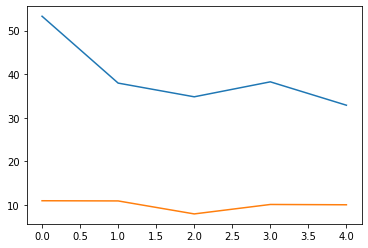

In [43]:
scores = train(config,probabilistic_route)
scores1 = train(config,route_from_distance)

plt.plot(scores)
plt.plot(scores1)

# Train the network

- Loss is the difference in loss between the previous route distribution and the current one.
- We want to increase/decrease the log probability of choosing that 'action/distribution' based on the loss difference.
- We update the log probs with the gradiant of the outcome


In [69]:
def train_network(policy,optimizer,config):
    scores = []
    for e in range(config.episodes):
        routes = gen_random_route(10)
        goals = gen_random_goals(10)
        elevation = Gym(routes,goals)
        print('starting loss',elevation.loss)
        for i in range(config.tmax):
#             current_dist = np.sum(elevation.routes,axis = 0)
#             nd_distance = elevation.goals - current_dist
#             prev_loss = np.mean((nd_distance)**2)
#             print('prev_loss',prev_loss)
            # Record loss and distance
            state = elevation.L2
            prev_loss = elevation.loss
#             print('prev_loss',prev_loss)
            # Pass distance into network
            suggestion = policy(state)
            # Get route from suggestion
            route = route_from_suggestion(suggestion.detach().cpu().squeeze(0).numpy())
            # Update gym
            elevation.update_route(route)
            # Get new loss
            loss = elevation.loss
            # Get improvement
#             route_loss = -torch.from_numpy(np.array(loss - prev_loss))
#             log_probs = torch.log(suggestion).float()
#             difference = (torch.from_numpy(state).float() - suggestion)
#             grad = (difference * route_loss).mean()
                
            
            
#             print('loss - prev_loss',loss - prev_loss)
#             print('route_loss',route_loss)
#             print('state',state)
#             print('suggestion',suggestion)
#             print('difference',difference)
#             print('grad',grad)
            
            optimizer.zero_grad()
            grad.backward()
            nn.utils.clip_grad_norm_(policy.parameters(), 10)
            optimizer.step()
        print('end loss',loss)
        scores.append(loss)
    return policy,scores

In [70]:
tic = time.time()
policy,scores = train_network(suggestion_engine,optimizer,config)
toc = time.time()
print('time taken {}'.format((toc-tic)/60))

starting loss 461.6113653687229
loss - prev_loss -49.566295610265
route_loss tensor(49.5663, dtype=torch.float64)
state [ 7.20653698 -0.26275429 -3.18459304 -3.88447424  0.12528459  5.83781599
 -0.87731406 -1.99671018 -1.97956675 -0.984225    6.34680061 -0.6835305
 -0.14215459 -2.53111845 -2.98999708 -2.79905934 -5.97582811  8.77488744
  2.87624072  0.57146837  0.91084509 -1.88659237 -2.4719618   8.09047818
 -2.350619   -3.68178983 -1.37687489 -0.68119446  2.71665185 -1.25022412
 -1.54309718  1.06558473 -0.98891527  4.01470244 -0.70555634 -4.1336568
 -1.8792381   2.7037488 ]
suggestion tensor([[0.2127, 0.2043, 0.1193, 0.2436, 0.2202, 0.4326, 0.0836, 0.1555, 0.2060,
         0.1223, 0.2013, 0.3445, 0.1252, 0.1613, 0.1676, 0.3725, 0.4039, 0.2235,
         0.2528, 0.1014, 0.2536, 0.2588, 0.1334, 0.1810, 0.2732, 0.1740, 0.2681,
         0.1037, 0.1724, 0.1850, 0.1441, 0.1883, 0.3103, 0.1672, 0.1542, 0.2165,
         0.2576, 0.2044]], grad_fn=<CatBackward>)
difference tensor([[ 6.9939, -0.4

route_loss tensor(37.2010, dtype=torch.float64)
state [ 6.20653698 -2.26275429 -0.18459304 -1.88447424 -1.87471541  7.83781599
 -2.87731406 -0.99671018 -2.97956675 -0.984225    8.34680061 -2.6835305
 -2.14215459 -2.53111845 -0.98999708 -4.79905934 -2.97582811  7.77488744
  2.87624072  1.57146837 -0.08915491 -3.88659237 -0.4719618   6.09047818
 -1.350619   -0.68178983 -2.37687489 -1.68119446  6.71665185 -3.25022412
 -1.54309718  0.06558473 -1.98891527  2.01470244 -2.70555634 -0.1336568
 -2.8792381   3.7037488 ]
suggestion tensor([[0.1916, 0.1386, 0.1889, 0.2341, 0.2468, 0.4968, 0.1139, 0.1050, 0.1129,
         0.1713, 0.2320, 0.3486, 0.1438, 0.1511, 0.1245, 0.3202, 0.4913, 0.1885,
         0.2662, 0.0640, 0.2695, 0.2713, 0.1291, 0.1107, 0.2710, 0.1303, 0.3398,
         0.1481, 0.1676, 0.1810, 0.0990, 0.2526, 0.2999, 0.1352, 0.1296, 0.1825,
         0.2719, 0.2808]], grad_fn=<CatBackward>)
difference tensor([[ 6.0149, -2.4014, -0.3735, -2.1186, -2.1215,  7.3410, -2.9913, -1.1017,
       

suggestion tensor([[0.2020, 0.1522, 0.2127, 0.2266, 0.2066, 0.5478, 0.1134, 0.1008, 0.1406,
         0.0973, 0.1413, 0.3160, 0.1373, 0.2360, 0.1694, 0.2701, 0.4985, 0.2314,
         0.2772, 0.0564, 0.2582, 0.2258, 0.1825, 0.1411, 0.1912, 0.1279, 0.3507,
         0.1891, 0.1115, 0.0754, 0.1053, 0.3268, 0.3811, 0.2174, 0.2212, 0.2241,
         0.1803, 0.1570]], grad_fn=<CatBackward>)
difference tensor([[ 1.8977,  2.7568, -1.4850, -3.1199, -1.0495, -1.5966,  2.8735, -1.7530,
          1.1638, -1.6878,  0.2370,  4.8391, -1.7864, -1.1316, -3.1581,  2.7059,
          0.0583, -3.7642,  3.3999,  0.7694, -1.0750, -2.2186, -1.8757,  7.0388,
          1.3803, -1.9756, -7.3411, -0.1024,  9.8868, -2.0741, -2.1052, -0.3265,
         -6.3809,  1.3858, -3.1044, -1.1680,  0.4914,  1.3951]],
       grad_fn=<SubBackward0>)
grad tensor(-3.2770, grad_fn=<MeanBackward0>)
loss - prev_loss -0.6213608001265243
route_loss tensor(0.6214, dtype=torch.float64)
state [ 2.09962835e+00  2.90895437e+00 -1.27233835e+00

route_loss tensor(-2.2478, dtype=torch.float64)
state [ 2.09962835e+00  2.90895437e+00 -1.27233835e+00 -8.93348832e-01
 -2.84289553e+00 -5.04875032e+00  3.98692880e+00 -6.52198310e-01
  1.30446124e+00  4.09558592e-01  2.37834617e+00  4.15512536e+00
 -1.64913018e+00 -1.89560615e+00 -2.98873520e+00  5.97604355e+00
 -4.44323238e+00 -1.53281118e+00  2.67714250e+00  8.25755862e-01
 -8.16835665e-01  1.00716305e+00 -3.69322575e+00  6.17988053e+00
 -3.42850661e+00 -8.47696309e-01 -2.99038222e+00  1.08670461e+00
  5.99825866e+00 -9.98693209e-01 -9.99965542e-01  2.58267854e-04
 -3.99985818e+00  1.60321589e+00 -1.88317766e+00 -1.94387124e+00
  6.71747021e-01  1.55208600e+00]
suggestion tensor([[0.1961, 0.1537, 0.1549, 0.2515, 0.2437, 0.3363, 0.1485, 0.1549, 0.2265,
         0.1338, 0.1872, 0.2300, 0.1494, 0.2419, 0.1915, 0.2827, 0.4263, 0.2909,
         0.2253, 0.1386, 0.2272, 0.2105, 0.1984, 0.1750, 0.1814, 0.2026, 0.2566,
         0.1844, 0.1654, 0.1463, 0.1932, 0.2271, 0.2680, 0.2268, 0.1859, 

loss - prev_loss 7.7777062517888
route_loss tensor(-7.7777, dtype=torch.float64)
state [-0.71049435  2.25998898 -0.89911178 -0.60032533 -0.05005752  1.82485323
 -0.45950562  0.72588323 -0.94790943 -1.14332141 -0.72389244  5.70052516
 -2.08580039  0.10752385 -2.99835618  4.84431227 -4.74945384 -0.09485843
  5.39314945  0.89427626 -2.08020154 -3.3267911  -0.88043307  5.5013597
 -0.24794734 -0.4988229  -3.94012349 -0.81446597  0.75878339  3.80991686
  0.80596559 -0.57866647 -4.79599936  8.72328547 -1.90421075 -1.9368388
 -2.89891858 -1.98331734]
suggestion tensor([[0.2288, 0.1232, 0.2102, 0.2327, 0.2050, 0.4955, 0.1511, 0.1140, 0.1367,
         0.1027, 0.1567, 0.3288, 0.2133, 0.1785, 0.1227, 0.4324, 0.3056, 0.2620,
         0.3598, 0.1241, 0.1932, 0.1957, 0.1271, 0.1457, 0.2519, 0.1559, 0.2599,
         0.1866, 0.1808, 0.1828, 0.1243, 0.2318, 0.2803, 0.1955, 0.2440, 0.1788,
         0.2038, 0.1779]], grad_fn=<CatBackward>)
difference tensor([[-0.9393,  2.1368, -1.1093, -0.8331, -0.2551,  

loss - prev_loss 6.064047244036544
route_loss tensor(-6.0640, dtype=torch.float64)
state [-1.45758546  0.26971588  1.94428361 -0.78599104  0.02957701  4.07758202
 -2.44262803  1.16374639 -0.90851377 -1.8901866   2.74653065 -1.30921
 -3.22870894  0.56624902  1.22513927 -5.19032171  4.3866538   0.80366792
  5.64631842 -0.12906636 -3.57535776 -0.96630716 -0.97558714  2.90619405
 -0.32442856  1.39497593 -1.9894613  -1.98728012 -2.18881359  3.37188792
 -3.87694076  3.15605104 -0.4621846   5.7730356  -1.79762084  0.51040943
 -0.83786958 -3.64795461]
suggestion tensor([[0.1780, 0.1137, 0.1611, 0.2243, 0.3227, 0.5155, 0.1367, 0.1150, 0.1180,
         0.1148, 0.1754, 0.2497, 0.2106, 0.2812, 0.0830, 0.3062, 0.3851, 0.3087,
         0.3358, 0.1276, 0.2593, 0.1644, 0.1129, 0.0986, 0.1953, 0.1526, 0.2493,
         0.3041, 0.1918, 0.2128, 0.1449, 0.2292, 0.2214, 0.1536, 0.1534, 0.1430,
         0.2328, 0.3172]], grad_fn=<CatBackward>)
difference tensor([[-1.6356,  0.1560,  1.7831, -1.0103, -0.2932, 

difference tensor([[-1.6543, -0.8537,  3.7488,  0.9967, -3.2375,  5.6073, -0.5851, -2.9634,
         -2.0476, -1.0112,  2.5373, -0.5468, -2.4301,  0.3206, -0.8810, -5.5036,
          2.9875,  1.5162,  2.3094,  2.7353, -3.8159, -1.1229, -1.1059,  5.8001,
          0.4811,  0.2437, -4.2889, -3.2360, -2.3980,  0.1707, -2.0273,  2.9438,
          0.3109,  5.5760,  1.0264, -1.6420, -3.0419, -2.9185]],
       grad_fn=<SubBackward0>)
grad tensor(-0.5307, grad_fn=<MeanBackward0>)
loss - prev_loss -4.805595625830961
route_loss tensor(4.8056, dtype=torch.float64)
state [-1.45758546  0.26971588  3.94428361  1.21400896 -3.97042299  6.07758202
 -0.44262803 -2.83625361 -1.90851377 -0.8901866   2.74653065 -0.30921
 -3.22870894  1.56624902 -0.77486073 -4.19032171  2.3866538   1.80366792
  2.64631842  2.87093364 -2.57535776 -0.96630716 -1.97558714  5.90619405
  0.67557144  1.39497593 -4.9894613  -2.98728012 -1.18881359  0.37188792
 -1.87694076  2.15605104  0.5378154   5.7730356   1.20237916 -2.48959057

loss - prev_loss -26.641645312956257
route_loss tensor(26.6416, dtype=torch.float64)
state [ 4.31183929 -1.18137134 -1.78980689 -1.58371666  0.24305561  2.77486353
 -0.38607668 -0.95731877 -1.13325103 -0.29821704  4.57296032 -1.73095988
 -0.96388344 -1.97123283  0.09311583  5.76747792 -2.84501908 -2.92245885
  4.17676076  0.67453498 -0.88378481 -0.98219999 -2.98531095 -1.71723906
  3.8201136  -1.6201528  -0.39957964 -0.08314209 -3.05725204  7.83570669
 -0.8761262  -1.98130774 -1.92102071  5.44307668  2.46570075 -1.92126935
 -1.99181096 -3.99569711]
suggestion tensor([[0.2195, 0.1589, 0.1744, 0.2208, 0.2264, 0.2886, 0.1594, 0.1530, 0.1995,
         0.1994, 0.2186, 0.1700, 0.1580, 0.2481, 0.2053, 0.3437, 0.3799, 0.2764,
         0.2803, 0.1702, 0.1747, 0.2135, 0.1613, 0.1952, 0.2083, 0.2025, 0.1996,
         0.1944, 0.2351, 0.2060, 0.1916, 0.1571, 0.2102, 0.2265, 0.1982, 0.1935,
         0.1827, 0.1991]], grad_fn=<CatBackward>)
difference tensor([[ 4.0924, -1.3403, -1.9642, -1.8045,  0.0

grad tensor(6.0269, grad_fn=<MeanBackward0>)
loss - prev_loss -6.736598063560166
route_loss tensor(6.7366, dtype=torch.float64)
state [ 0.3295036   3.21910318  0.41416699 -1.10426684 -2.85850692 -0.44803199
  7.05910498  0.24981024 -4.96356118 -1.89732205  2.80653806  2.09186471
  0.10174687 -2.43678938 -2.56336025  1.94308744  1.10745277 -3.05054021
  5.29227244 -0.65479251 -3.01824413 -0.81819905 -0.80103675  1.84372058
 -3.77639551  2.53354454 -3.50850008  2.90763046  7.20434236  0.33576421
 -1.75866125 -1.82736382 -3.95408149  7.73355124  0.12790707  0.01452683
 -1.98703482 -5.88895032]
suggestion tensor([[0.1821, 0.1391, 0.1608, 0.2519, 0.2662, 0.3947, 0.1379, 0.1511, 0.1986,
         0.1178, 0.1948, 0.2444, 0.1789, 0.2425, 0.1394, 0.3010, 0.4213, 0.2777,
         0.2848, 0.1369, 0.2370, 0.1702, 0.1711, 0.1523, 0.1755, 0.1701, 0.2832,
         0.2189, 0.2064, 0.1761, 0.1824, 0.1848, 0.2502, 0.1966, 0.1858, 0.1816,
         0.2108, 0.2252]], grad_fn=<CatBackward>)
difference tensor

route_loss tensor(30.0686, dtype=torch.float64)
state [ 0.3295036   2.21910318  0.41416699 -1.10426684 -1.85850692 -3.44803199
  7.05910498 -2.75018976 -0.96356118  0.10267795  5.80653806  1.09186471
  1.10174687 -5.43678938 -2.56336025  0.94308744 -0.89254723 -0.05054021
  4.29227244  1.34520749 -0.01824413 -2.81819905 -2.80103675  1.84372058
 -0.77639551 -2.46645546 -2.50850008  3.90763046  8.20434236 -0.66423579
 -1.75866125 -1.82736382 -3.95408149  6.73355124 -3.87209293 -0.98547317
 -0.98703482 -0.88895032]
suggestion tensor([[0.2071, 0.1151, 0.1089, 0.3282, 0.2406, 0.4390, 0.1566, 0.1032, 0.1809,
         0.1202, 0.2156, 0.2344, 0.1341, 0.2729, 0.1429, 0.2693, 0.4648, 0.2660,
         0.2809, 0.1419, 0.2411, 0.1710, 0.1651, 0.1207, 0.1703, 0.2611, 0.2791,
         0.1687, 0.1899, 0.1930, 0.1601, 0.1717, 0.2853, 0.1913, 0.1975, 0.2172,
         0.1632, 0.2308]], grad_fn=<CatBackward>)
difference tensor([[ 0.1224,  2.1040,  0.3053, -1.4325, -2.0991, -3.8870,  6.9025, -2.8534,
     

route_loss tensor(-0.1997, dtype=torch.float64)
state [ 1.8642777   4.43261264 -1.34848484 -2.95552615 -1.99287934 -1.15472849
 -0.95124411  0.26130437  3.46875832 -1.62409008  4.84501624  3.6988959
 -1.79479292 -2.89202792 -3.85709129  8.10765401 -3.22111488 -4.88653913
  3.07525844  1.83885669 -0.71837741 -0.74649193 -3.4492458   2.06561088
  3.31661956  1.12600696 -3.63389782 -2.87433958  3.95829223 -0.59209355
  0.45321043 -0.87346091 -2.9459482   0.97873841  3.90021744 -0.92728115
 -1.99177088 -1.95990382]
suggestion tensor([[0.1634, 0.1334, 0.2719, 0.2443, 0.1869, 0.4449, 0.1428, 0.1179, 0.1702,
         0.1243, 0.1498, 0.2095, 0.1460, 0.3207, 0.1741, 0.2888, 0.5037, 0.2075,
         0.3546, 0.0812, 0.1891, 0.1880, 0.1871, 0.1702, 0.1401, 0.0977, 0.2703,
         0.3217, 0.1966, 0.1317, 0.1607, 0.1964, 0.3146, 0.1925, 0.2231, 0.2168,
         0.1966, 0.1710]], grad_fn=<CatBackward>)
difference tensor([[ 1.7009,  4.2992, -1.6204, -3.1998, -2.1798, -1.5996, -1.0940,  0.1434,
      

loss - prev_loss -2.211900061697463
route_loss tensor(2.2119, dtype=torch.float64)
state [ 1.8642777   3.43261264 -1.34848484 -2.95552615 -0.99287934  0.84527151
  0.04875589 -0.73869563  1.46875832 -1.62409008  1.84501624 -0.3011041
  0.20520708 -1.89202792  0.14290871  6.10765401 -3.22111488 -2.88653913
  3.07525844  3.83885669 -2.71837741 -0.74649193 -3.4492458   1.06561088
  3.31661956  1.12600696 -2.63389782 -2.87433958  6.95829223 -1.59209355
 -0.54678957 -3.87346091 -0.9459482   2.97873841  4.90021744 -1.92728115
 -4.99177088 -0.95990382]
suggestion tensor([[0.1675, 0.1333, 0.2473, 0.2225, 0.2294, 0.3586, 0.1512, 0.1482, 0.1870,
         0.1550, 0.1710, 0.2122, 0.1708, 0.2566, 0.1894, 0.3320, 0.4369, 0.2311,
         0.3386, 0.1027, 0.1824, 0.1882, 0.1882, 0.1875, 0.1758, 0.1150, 0.2513,
         0.2704, 0.2256, 0.1680, 0.1922, 0.1688, 0.2453, 0.1853, 0.2003, 0.1934,
         0.2185, 0.2024]], grad_fn=<CatBackward>)
difference tensor([[ 1.6968,  3.2993, -1.5958, -3.1780, -1.2223

grad tensor(5.1685, grad_fn=<MeanBackward0>)
loss - prev_loss 12.952595870743721
route_loss tensor(-12.9526, dtype=torch.float64)
state [ 4.82112719e+00 -6.91644352e-02  3.05306059e-01 -3.68272552e+00
 -1.37454329e+00 -1.78142274e-01  6.49981766e+00  6.03507949e-01
 -2.98325822e+00 -3.94192511e+00 -9.96614590e-01 -5.36463633e-01
  3.28649902e+00 -4.92784495e-01 -1.26063630e+00 -2.47760562e+00
  1.24389974e+00  1.23370588e+00 -4.77577491e+00  1.98029166e+00
 -1.20213285e+00  6.59140473e-01  3.33847563e+00  4.66491952e+00
 -2.06144026e+00 -8.77017333e-01 -1.22867132e+00 -4.97790610e-01
  6.68628001e+00 -5.28291214e-01 -2.39258113e+00 -9.91573422e-01
 -2.77383425e+00 -1.49133165e-03  1.04490510e+00  9.94384036e-01
 -1.99169755e-01 -1.83862805e+00]
suggestion tensor([[0.2080, 0.1806, 0.1508, 0.2460, 0.2146, 0.3835, 0.1372, 0.1541, 0.1820,
         0.1432, 0.1862, 0.2779, 0.1386, 0.2253, 0.1720, 0.2925, 0.4407, 0.2667,
         0.2214, 0.1231, 0.2410, 0.2482, 0.1663, 0.1496, 0.2290, 0.1804,

loss - prev_loss 41.890590056686335
route_loss tensor(-41.8906, dtype=torch.float64)
state [ 5.82112719 -3.06916444 -0.69469394 -2.68272552  0.62545671 -2.17814227
  6.49981766 -1.39649205 -0.98325822 -1.94192511  1.00338541  3.46353637
  0.28649902 -2.49278449 -2.2606363   0.52239438  0.24389974 -0.76629412
  0.22422509  0.98029166 -4.20213285 -0.34085953  3.33847563  5.66491952
 -2.06144026 -0.87701733 -2.22867132 -0.49779061  4.68628001 -1.52829121
 -0.39258113 -0.99157342 -1.77383425  0.99850867  1.0449051  -2.00561596
  0.80083024 -0.83862805]
suggestion tensor([[0.1984, 0.1748, 0.1475, 0.2386, 0.2408, 0.3727, 0.1281, 0.1589, 0.1941,
         0.1463, 0.2172, 0.2831, 0.1445, 0.1851, 0.1701, 0.3135, 0.4410, 0.2455,
         0.2080, 0.1496, 0.2138, 0.2555, 0.1731, 0.1816, 0.2427, 0.1676, 0.2346,
         0.1734, 0.1622, 0.1877, 0.1865, 0.2279, 0.2357, 0.1686, 0.1595, 0.2059,
         0.2246, 0.2412]], grad_fn=<CatBackward>)
difference tensor([[ 5.6227, -3.2439, -0.8422, -2.9214,  0.3

loss - prev_loss -62.18977023508944
route_loss tensor(62.1898, dtype=torch.float64)
state [ 5.28164998e+00 -2.42574540e+00 -1.89093812e+00 -9.70809329e-01
  5.84287463e-03  7.60945938e+00 -1.61336299e+00  3.68684525e-03
 -4.99991602e+00 -9.99867216e-01  2.00101277e+00  6.23942581e-01
 -1.40116441e+00 -4.56235420e-01 -7.67555522e-01 -8.13435085e-01
 -6.25396040e-02  8.75974689e-01  5.10287472e+00  7.98534920e-01
 -8.13188122e-01 -8.26560287e-01 -4.26166123e+00  8.42041805e+00
 -3.46976378e+00 -1.95634798e+00 -1.99919995e+00 -9.95106344e-01
 -7.38791532e-01  6.60403461e+00  3.05556501e-01 -1.78353377e+00
 -4.38726581e+00  2.98324161e+00  1.01836305e+00 -6.81899914e-01
 -1.50724520e+00 -1.81245954e+00]
suggestion tensor([[0.2204, 0.1988, 0.1152, 0.2283, 0.2374, 0.3931, 0.1030, 0.1514, 0.2054,
         0.1471, 0.2168, 0.3089, 0.1461, 0.1840, 0.1441, 0.3762, 0.4137, 0.2101,
         0.2486, 0.1075, 0.2596, 0.2719, 0.1124, 0.1590, 0.2789, 0.1713, 0.2513,
         0.1395, 0.1685, 0.2310, 0.15

suggestion tensor([[0.2016, 0.1685, 0.1503, 0.2650, 0.2146, 0.3629, 0.1513, 0.1337, 0.2311,
         0.1210, 0.1879, 0.2551, 0.1458, 0.2519, 0.1594, 0.2670, 0.4512, 0.2819,
         0.2086, 0.1713, 0.2014, 0.2482, 0.1705, 0.2146, 0.2142, 0.1368, 0.2022,
         0.2321, 0.1859, 0.1983, 0.1974, 0.1789, 0.2395, 0.1762, 0.1412, 0.2281,
         0.2446, 0.2098]], grad_fn=<CatBackward>)
difference tensor([[ 4.8346, -0.2618, -3.1286, -2.2313, -0.2129,  1.7528,  0.1564, -2.0454,
         -0.5091, -0.3548,  5.4141, -0.3866,  0.2676, -3.1782, -3.1169,  3.1599,
         -3.2361, -0.9238, -4.1995,  3.0542, -2.4066,  0.6075,  1.9443,  3.9148,
         -0.8370, -2.8703, -1.2292,  0.0217, -2.0327, -1.2824, -0.4414,  1.3109,
          1.4456, -2.9141,  2.2327, -0.9637, -0.5540,  1.1992]],
       grad_fn=<SubBackward0>)
grad tensor(1.8302, grad_fn=<MeanBackward0>)
loss - prev_loss 18.007797068352858
route_loss tensor(-18.0078, dtype=torch.float64)
state [ 5.03620803e+00 -9.33476114e-02 -1.97827433e+00

grad tensor(5.5679, grad_fn=<MeanBackward0>)
loss - prev_loss 9.717460722448038
route_loss tensor(-9.7175, dtype=torch.float64)
state [ 4.03620803e+00  1.90665239e+00 -1.97827433e+00 -3.96622669e+00
  1.64059202e-03  4.11574485e+00 -6.92293159e-01 -1.91174284e+00
  7.22002372e-01 -2.23371122e+00  6.60196284e+00 -1.13150352e+00
 -1.58658844e+00 -2.92631836e+00 -9.57552516e-01  3.42689712e+00
 -2.78498185e+00 -6.41915264e-01 -1.99092555e+00  1.22552174e+00
 -2.20516362e+00 -1.44238897e-01  3.11480633e+00  6.12944603e+00
 -6.22751432e-01 -1.73351808e+00 -1.02698974e+00 -2.74618677e+00
 -8.46796109e-01  9.15887094e-01 -1.24399621e+00  4.89763000e-01
  6.85142226e-01 -1.73788701e+00  1.37396064e+00 -1.73561024e+00
  1.69056804e+00  4.08968563e-01]
suggestion tensor([[0.2090, 0.1772, 0.1545, 0.2377, 0.2216, 0.4518, 0.1207, 0.1090, 0.1835,
         0.1349, 0.1713, 0.2790, 0.1282, 0.2565, 0.1650, 0.2868, 0.4689, 0.2443,
         0.2506, 0.1168, 0.2258, 0.2589, 0.1478, 0.2024, 0.2260, 0.1359, 0

suggestion tensor([[0.1996, 0.1961, 0.1339, 0.2171, 0.2533, 0.4001, 0.0899, 0.1745, 0.2005,
         0.1350, 0.1996, 0.2733, 0.1488, 0.2113, 0.1670, 0.3430, 0.4015, 0.2556,
         0.2450, 0.1325, 0.2352, 0.2378, 0.1494, 0.1903, 0.2129, 0.1958, 0.2481,
         0.1529, 0.1893, 0.2027, 0.1718, 0.1801, 0.2562, 0.1605, 0.1700, 0.1897,
         0.2277, 0.2522]], grad_fn=<CatBackward>)
difference tensor([[ 6.5818e+00, -6.5837e-01, -2.8565e+00, -2.1906e+00, -1.8763e+00,
         -6.7736e-01,  4.1435e+00, -2.1445e+00, -1.1996e+00, -1.1221e+00,
          6.5856e+00, -3.7606e+00,  4.8827e-01, -2.1637e+00, -2.1496e+00,
         -1.6752e-03, -1.1861e+00,  1.8779e-01,  1.1136e+00,  1.6491e+00,
         -5.1538e+00,  1.1394e+00,  2.5173e-01,  7.5565e+00, -1.6977e+00,
         -9.0539e-01, -5.1315e+00, -8.2183e-01, -5.9255e-01,  4.8969e+00,
         -1.1479e+00, -1.3674e+00, -2.7890e+00,  5.9683e+00, -1.1667e+00,
         -2.5772e+00, -2.0962e+00, -1.1283e+00]], grad_fn=<SubBackward0>)
grad tensor(

loss - prev_loss -47.04440677070954
route_loss tensor(47.0444, dtype=torch.float64)
state [ 6.89127132 -2.08597478 -0.08390061 -1.77208895 -2.94930698 -2.7305578
  4.81568588 -1.58933252 -1.78738755  1.29159199  4.19416595 -2.51125656
  0.97109272 -0.72732605 -1.92667606  4.67482035 -3.0481695  -1.62665086
  6.08657916  0.81753167 -1.05287377 -3.96283433 -1.88840273  8.13554271
 -4.60752832 -1.7804995  -0.98372832 -0.76378657  4.85074708  0.33570283
 -0.56499838 -2.66216477 -1.95928676  0.73374812  2.96894262  0.64881217
 -0.75901218 -3.59249073]
suggestion tensor([[0.2255, 0.1602, 0.1242, 0.2383, 0.2518, 0.3375, 0.1455, 0.1688, 0.2010,
         0.1471, 0.2341, 0.2262, 0.1418, 0.2224, 0.1754, 0.2957, 0.4214, 0.2829,
         0.2538, 0.1628, 0.2388, 0.1725, 0.1720, 0.1505, 0.2156, 0.2162, 0.2418,
         0.1758, 0.1762, 0.1842, 0.2152, 0.2057, 0.2187, 0.2025, 0.1628, 0.2199,
         0.1948, 0.2200]], grad_fn=<CatBackward>)
difference tensor([[ 6.6657, -2.2462, -0.2081, -2.0104, -3.201

suggestion tensor([[0.2182, 0.1581, 0.1486, 0.2136, 0.2614, 0.3380, 0.1454, 0.1624, 0.1951,
         0.1590, 0.2393, 0.2457, 0.1602, 0.1822, 0.1725, 0.3067, 0.4114, 0.2819,
         0.2214, 0.1533, 0.2164, 0.2018, 0.2072, 0.1851, 0.1995, 0.1930, 0.2292,
         0.1932, 0.1836, 0.1885, 0.1989, 0.2289, 0.2001, 0.1740, 0.1594, 0.2100,
         0.2133, 0.2434]], grad_fn=<CatBackward>)
difference tensor([[ 5.6730, -2.2441,  0.7675, -3.9857, -1.2107, -3.0686,  4.6702, -2.7517,
          0.0175,  0.1325,  3.9549,  0.2430, -1.1891, -1.9096, -2.0992,  3.3681,
         -4.4595,  0.0914,  4.8651, -3.3357, -0.2693, -0.1646, -2.0956,  6.9505,
         -0.8071, -1.9735, -1.2129, -3.9570,  4.6672, -2.8528,  1.2361, -3.8911,
         -0.1594, -1.4403,  3.8096, -2.5612,  1.0277, -1.8359]],
       grad_fn=<SubBackward0>)
grad tensor(0.8922, grad_fn=<MeanBackward0>)
loss - prev_loss -28.129336343920272
route_loss tensor(28.1293, dtype=torch.float64)
state [ 5.89127132 -2.08597478  0.91609939 -3.77208895

loss - prev_loss 15.174785933514727
route_loss tensor(-15.1748, dtype=torch.float64)
state [ 3.23235099  0.44447953  1.93509826 -2.86500248 -2.7469263  -4.96460679
  0.42020613  4.41951972 -0.76524151  0.89012244  6.47721386 -2.8498584
 -0.64078163 -1.99765061 -0.98892322 -1.30582745  1.26478667  0.04104078
  0.077921    1.94265153  0.74212106 -0.9181507  -1.84454289  0.71368784
 -2.92968741  3.038166    0.02533182 -0.84749826  8.7738441  -0.94302473
 -0.92219907 -2.91992918 -3.98869112  0.02371986  3.86751195 -2.24690478
 -0.6680513  -0.97627573]
suggestion tensor([[0.1804, 0.1500, 0.1706, 0.2125, 0.2866, 0.3486, 0.1358, 0.1650, 0.1860,
         0.1645, 0.1959, 0.2015, 0.1687, 0.2537, 0.1802, 0.2825, 0.4574, 0.2601,
         0.2364, 0.1147, 0.2663, 0.1936, 0.1889, 0.1400, 0.1695, 0.1966, 0.2797,
         0.2142, 0.1802, 0.1664, 0.1835, 0.2157, 0.2543, 0.2174, 0.1681, 0.1864,
         0.1767, 0.2514]], grad_fn=<CatBackward>)
difference tensor([[ 3.0519,  0.2945,  1.7645, -3.0775, -3.03

suggestion tensor([[0.1763, 0.2027, 0.1818, 0.2390, 0.2002, 0.2738, 0.1249, 0.1786, 0.2323,
         0.1905, 0.2042, 0.1600, 0.1249, 0.2961, 0.2148, 0.3504, 0.4361, 0.2134,
         0.2802, 0.1293, 0.1925, 0.2163, 0.1817, 0.1932, 0.2098, 0.1549, 0.2504,
         0.1917, 0.2178, 0.1760, 0.1663, 0.1633, 0.2766, 0.2608, 0.2063, 0.1953,
         0.1562, 0.1814]], grad_fn=<CatBackward>)
difference tensor([[ 4.8590e+00,  1.7786e-01, -9.4875e-01, -1.3743e-01, -4.9507e+00,
          9.0741e-01,  4.0331e+00, -1.8932e+00, -2.1848e+00, -1.8626e+00,
         -5.1313e-01,  2.6929e+00, -1.9254e+00, -2.3261e+00,  1.0718e+00,
          1.9151e+00, -1.7643e+00, -1.1508e+00, -2.2093e+00,  6.1681e+00,
         -2.6438e+00, -1.1576e+00, -1.1574e+00, -1.3618e+00,  7.4560e+00,
         -9.9762e-01, -9.7960e-01, -5.1169e+00, -4.0622e-03,  6.1041e+00,
          1.6297e-02, -2.1120e+00, -5.0044e+00, -9.8049e-01,  2.4147e+00,
         -9.5893e-01, -1.1208e+00, -3.5443e-01]], grad_fn=<SubBackward0>)
grad tensor(

suggestion tensor([[0.1671, 0.1965, 0.2436, 0.2258, 0.1670, 0.3265, 0.1197, 0.1691, 0.2198,
         0.1649, 0.1653, 0.1739, 0.1332, 0.3110, 0.2166, 0.3797, 0.4105, 0.2098,
         0.3139, 0.1169, 0.1766, 0.2219, 0.1707, 0.2234, 0.1739, 0.1149, 0.2415,
         0.2463, 0.2185, 0.1500, 0.1614, 0.1588, 0.3113, 0.2707, 0.2207, 0.1806,
         0.1836, 0.1443]], grad_fn=<CatBackward>)
difference tensor([[-1.3182e-01,  1.1842e+00, -1.0106e+00, -1.2431e-01, -9.1745e-01,
          1.8547e+00,  2.0383e+00, -8.8368e-01, -3.1723e+00, -8.3697e-01,
         -4.7416e-01,  1.6790e+00, -9.3375e-01, -1.3410e+00,  6.9984e-02,
          3.8858e+00, -4.7387e+00, -1.4709e-01, -5.2431e+00,  9.1805e+00,
         -6.2783e-01, -1.1632e+00, -3.1464e+00, -2.3920e+00,  5.4919e+00,
          1.0424e+00, -1.9708e+00, -3.1716e+00, -4.6965e-03,  7.1301e+00,
         -9.7888e-01, -2.1075e+00, -5.0390e+00,  9.6432e-03,  4.4002e+00,
         -3.9443e+00, -1.1483e+00, -3.1734e-01]], grad_fn=<SubBackward0>)
grad tensor(

loss - prev_loss -14.457328669287847
route_loss tensor(14.4573, dtype=torch.float64)
state [ 1.15012685  2.46747534 -0.02801434  0.12696341 -3.71655127  3.25880648
  2.01377869 -1.6690079  -1.97279847 -1.6307788   2.29477556 -0.03316184
 -0.29903644 -0.91126155 -1.05131574  3.1743697  -3.23500384  0.06063414
 -0.67960658  5.80255401 -0.5049347  -3.93215854 -0.68585418  1.99694723
 -1.513934    1.80415496 -0.65363995 -1.63352824  1.06576771 -0.52602439
  2.3887555   0.04346199 -2.97196081  1.93651443  1.25029906 -0.9480638
 -1.63476752 -0.60398217]
suggestion tensor([[0.2005, 0.1454, 0.1964, 0.2617, 0.1961, 0.3704, 0.1511, 0.1449, 0.1846,
         0.1491, 0.2016, 0.2217, 0.1556, 0.2319, 0.1892, 0.3435, 0.4173, 0.2391,
         0.2899, 0.1400, 0.1922, 0.1983, 0.1795, 0.1866, 0.1935, 0.1639, 0.2425,
         0.2135, 0.2081, 0.1937, 0.1706, 0.1668, 0.2608, 0.1820, 0.2258, 0.1974,
         0.1859, 0.2090]], grad_fn=<CatBackward>)
difference tensor([[ 0.9496,  2.3221, -0.2244, -0.1347, -3.91

loss - prev_loss 16.370172805486163
route_loss tensor(-16.3702, dtype=torch.float64)
state [ 6.55871069 -0.07594767 -0.82554597 -1.92383175 -3.73338529  4.82879993
 -0.9302343   0.36842752 -3.92718934 -0.33980381  0.12596092  0.01182703
 -0.349436   -0.58063084  0.79227888 -0.88811912 -3.48484217  4.37296129
  2.85986426  0.38734763  0.12792916 -2.21968909 -1.15545197  5.68661838
 -2.21470048 -0.89661472 -0.27376774 -2.30153543  0.6424538   0.75559006
  3.28972096 -1.88417181 -2.80359301  1.94497554 -2.40122524  2.03633909
 -2.44740599  0.86731661]
suggestion tensor([[0.2042, 0.1722, 0.1895, 0.2161, 0.2180, 0.3537, 0.1223, 0.1638, 0.1814,
         0.1789, 0.2178, 0.2923, 0.1549, 0.1527, 0.1824, 0.3543, 0.4583, 0.1874,
         0.2103, 0.0830, 0.2527, 0.2913, 0.1627, 0.1471, 0.2380, 0.1608, 0.3188,
         0.1354, 0.1656, 0.1902, 0.1369, 0.2222, 0.2852, 0.1850, 0.1498, 0.2085,
         0.2351, 0.2216]], grad_fn=<CatBackward>)
difference tensor([[ 6.3545, -0.2482, -1.0150, -2.1399, -3.9

loss - prev_loss 26.49982203819644
route_loss tensor(-26.4998, dtype=torch.float64)
state [ 6.55871069 -0.07594767 -0.82554597 -1.92383175 -3.73338529  3.82879993
 -1.9302343   0.36842752 -2.92718934  0.66019619 -0.87403908  0.01182703
  3.650564   -0.58063084 -2.20772112 -0.88811912 -3.48484217  4.37296129
  2.85986426  0.38734763 -1.87207084 -0.21968909 -1.15545197  4.68661838
 -1.21470048 -1.89661472 -1.27376774 -0.30153543 -0.3575462   2.75559006
  3.28972096 -0.88417181 -4.80359301  0.94497554 -1.40122524 -1.96366091
  1.55259401  0.86731661]
suggestion tensor([[0.2227, 0.2050, 0.1599, 0.1857, 0.2267, 0.3519, 0.1020, 0.1676, 0.2080,
         0.1705, 0.2019, 0.2873, 0.1560, 0.1621, 0.1927, 0.3758, 0.4227, 0.2015,
         0.2063, 0.0917, 0.2496, 0.3043, 0.1481, 0.1931, 0.2306, 0.1841, 0.2665,
         0.1257, 0.1888, 0.1987, 0.1558, 0.1834, 0.2732, 0.1916, 0.1485, 0.2114,
         0.2627, 0.1858]], grad_fn=<CatBackward>)
difference tensor([[ 6.3360, -0.2809, -0.9855, -2.1095, -3.96

loss - prev_loss 42.97931052766654
route_loss tensor(-42.9793, dtype=torch.float64)
state [-3.92777137 -1.74958179 -0.01839665  0.30916319  5.38658661  3.28483287
  2.47589961 -1.05790677 -1.71659624 -2.98622948 -0.59223252  4.41851833
  0.09619007 -1.99606682 -1.92640906  3.78106731 -2.68962843 -1.09143888
  0.03321698 -0.72498233 -1.87990223 -1.85970852  4.4313761  -1.69433531
 -2.85809377  5.60504088  0.55755091 -1.61016272  7.79928966 -2.46176532
 -0.52016269 -2.94456363 -1.87279801  6.32190044 -1.32277785 -0.90643019
 -3.62990102 -0.46279138]
suggestion tensor([[0.2411, 0.1398, 0.2551, 0.1857, 0.1782, 0.4391, 0.1413, 0.1579, 0.1427,
         0.1190, 0.1865, 0.2983, 0.2238, 0.1614, 0.1299, 0.4632, 0.2857, 0.2511,
         0.3412, 0.1474, 0.1778, 0.2174, 0.1162, 0.1664, 0.2227, 0.1342, 0.2360,
         0.2407, 0.1810, 0.2073, 0.1573, 0.2269, 0.2274, 0.2253, 0.1658, 0.1582,
         0.2865, 0.1642]], grad_fn=<CatBackward>)
difference tensor([[-4.1689, -1.8894, -0.2735,  0.1234,  5.20

difference tensor([[-2.6780,  1.0113,  2.9490, -3.2767,  0.9944,  6.1407, -1.0118, -4.1015,
         -1.1190, -0.9084,  3.8172, -0.4928, -0.1002, -2.1375, -2.0867, -1.4688,
         -4.0513,  4.5201,  3.2283, -0.5432, -1.1001, -0.5031, -2.0819,  6.5180,
         -2.5901, -2.1340, -1.0712, -1.7227,  7.2807, -0.7692, -3.0751, -3.1995,
         -1.2369,  3.3883, -2.8848,  0.8363, -0.0852, -2.2546]],
       grad_fn=<SubBackward0>)
grad tensor(-2.4661, grad_fn=<MeanBackward0>)
loss - prev_loss -21.693184145050168
route_loss tensor(21.6932, dtype=torch.float64)
state [-2.46823326  1.15420345  2.11473347 -2.04843061  1.24772695  6.59584371
 -0.87161492 -2.99499886 -0.99172675 -1.73750318  4.01876094 -0.17692784
  0.09095233 -1.94821766 -1.98456777 -2.10567874 -2.63312419  4.73880294
  3.52059662 -0.4583235  -0.85140451 -0.22506675 -1.98580186  6.64228731
 -2.30187678 -0.97441915 -1.84101418 -1.5249772   7.45721254 -0.5251664
 -2.96175428 -2.9831392  -0.98715267  3.53176458 -2.76127946  0.9885

difference tensor([[-0.6584, -1.9747,  0.9554,  0.6870, -0.0092,  3.1432, -0.0251, -0.1047,
         -1.1186, -2.8948,  3.8163, -0.4852, -3.0952, -1.1362, -0.0998, -1.4634,
         -1.0257,  1.4892,  4.2094,  0.4365, -5.0895,  0.5542, -1.1106,  4.5129,
         -1.5875, -0.1162, -2.0624, -1.7467,  5.2901,  0.2706, -1.0859, -2.2385,
         -3.2364,  3.3847, -4.9159,  0.8403,  1.9722, -2.2813]],
       grad_fn=<SubBackward0>)
grad tensor(2.0968, grad_fn=<MeanBackward0>)
loss - prev_loss 34.815649798141635
route_loss tensor(-34.8156, dtype=torch.float64)
state [ 5.31766738e-01 -1.84579655e+00  1.11473347e+00 -4.84306143e-02
  2.47726954e-01  3.59584371e+00  1.28385079e-01  5.00113983e-03
 -9.91726745e-01 -2.73750318e+00  4.01876094e+00 -1.17692784e+00
 -1.90904767e+00 -9.48217658e-01  1.54322302e-02 -1.10567874e+00
 -6.33124194e-01  1.73880294e+00  4.52059662e+00  5.41676497e-01
 -4.85140451e+00  7.74933252e-01 -9.85801864e-01  4.64228731e+00
 -2.30187678e+00  2.55808475e-02 -8.4101418

suggestion tensor([[0.1944, 0.1783, 0.1458, 0.2447, 0.2367, 0.3921, 0.1167, 0.1560, 0.2032,
         0.1320, 0.2113, 0.3159, 0.1535, 0.1703, 0.1491, 0.3465, 0.3868, 0.2667,
         0.2510, 0.1189, 0.2300, 0.2332, 0.1669, 0.1808, 0.2449, 0.1582, 0.2729,
         0.1433, 0.1925, 0.1727, 0.1471, 0.2165, 0.2713, 0.1721, 0.1800, 0.1869,
         0.2391, 0.2219]], grad_fn=<CatBackward>)
difference tensor([[ 4.2432, -0.4439, -0.4714, -1.9276, -2.4003,  0.9530,  3.8872,  0.2403,
         -3.6442, -2.4364,  2.7966, -0.7646,  0.0254, -0.9736, -2.0838, -0.6283,
         -5.1508,  4.7791,  3.1595, -1.9159, -1.3414, -1.9466,  1.0443,  7.1524,
         -1.0037, -0.8742, -6.1986, -0.0759,  3.6364, -0.1941,  0.1672, -1.5540,
         -3.0555,  3.1916, -1.1104,  0.9564, -1.8716, -2.1659]],
       grad_fn=<SubBackward0>)
grad tensor(3.2882, grad_fn=<MeanBackward0>)
loss - prev_loss 44.49997952239147
route_loss tensor(-44.5000, dtype=torch.float64)
state [ 4.43762858 -0.26561406 -0.32556045 -0.68290864 

loss - prev_loss 42.97033247159183
route_loss tensor(-42.9703, dtype=torch.float64)
state [ 1.22091200e+00  5.57684321e-01 -1.04355675e+00 -1.00607455e+00
  2.71034980e-01 -3.19527344e+00  4.75382708e+00  4.11173384e-01
 -1.97818745e+00  8.46041780e-03  1.24265660e+00 -2.54886429e-01
  1.31234253e+00 -9.78706995e-01 -1.32140571e+00  2.13873855e+00
 -1.76207288e+00 -3.76665672e-01  3.53800422e+00 -5.59410334e-01
 -9.86601818e-01  2.94135391e-03 -1.99493342e+00  3.21708920e+00
  2.29323975e+00 -2.40221758e-01 -1.36266743e+00 -3.90743977e+00
  6.98604852e+00 -1.92508566e+00 -3.12069989e+00  1.78222061e-02
 -1.95808518e+00  3.98555910e+00  2.62425923e+00 -1.44145551e+00
 -1.36528734e+00 -3.80307549e+00]
suggestion tensor([[0.2040, 0.1777, 0.1969, 0.1996, 0.2217, 0.2622, 0.1602, 0.2050, 0.1931,
         0.1795, 0.2128, 0.2078, 0.1799, 0.1892, 0.2103, 0.3408, 0.3601, 0.2991,
         0.2320, 0.1945, 0.1885, 0.1926, 0.1924, 0.2175, 0.2071, 0.1750, 0.1921,
         0.2083, 0.2041, 0.1949, 0.22

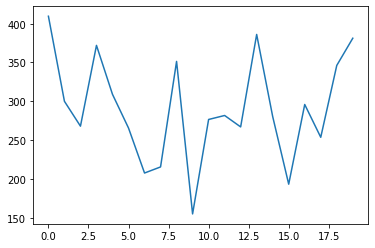

In [68]:
plt.plot(scores)